# Описание проекта
Задача - разработать модель для предсказания успешности стартапа (закроется или нет)

# Описание данных
Датасет состоит из двух файлов: тренировочный набор (около 53к записей) и тестовый набор (около 13к записей). Тренировочный набор содержит целевой признак status, указывающий на то, закрылся стартап или продолжает действовать. Временной период - '1970-01-01' по '2018-01-01'. Дата формирования выгрузки - '2018-01-01'

kaggle_startups_train_01.csv - информация (53 000) стартапах, которые будут использоваться в качестве обучающих данных.
kaggle_startups_test_01.csv - информация (13 000) стартапах, которые будут использоваться в качестве тестовых данных. Ваша задача - предсказать значение 'status' для каждого стартапа из этого датасета.
kaggle_startups_sample_submit_01.csv - файл с примером предсказаний в правильном формате.
name - идентификатор (название) стартапа в тестовом наборе.  
- status - целевой признак. Для каждого стартапа предскажите категориальное значение соответствующее прогнозу ['operating', 'closed'].
Описание полей данных
- name - Название стартапа
- category_list - Список категорий, к которым относится стартап
- funding_total_usd - Общая сумма финансирования в USD
- status - Статус стартапа (закрыт или действующий)
- country_code - Код страны
- state_code - Код штата
- region - Регион
- city - Город
- funding_rounds - Количество раундов финансирования
- founded_at - Дата основания
- first_funding_at - Дата первого раунда финансирования
- last_funding_at - Дата последнего раунда финансирования
- closed_at - Дата закрытия стартапа (если применимо)
- lifetime - Время существования стартапа в днях

In [1]:
!pip install phik -q
!pip install shap -q
!pip install imbalanced-learn -q

import numpy as np
import pandas as pd
from math import sqrt
from scipy import stats as st
import textwrap


from matplotlib import pyplot as plt
from matplotlib import rcParams, rcParamsDefault
import plotly.express as px
import seaborn as sns
from phik.report import plot_correlation_matrix


import phik


# загружаем класс pipeline
from sklearn.pipeline import Pipeline


# загружаем классы для подготовки данных
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (OneHotEncoder,
                                   OrdinalEncoder,
                                   StandardScaler,
                                   MinMaxScaler,
                                   RobustScaler,
                                   FunctionTransformer
                                  )
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score


# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import (roc_auc_score,
                             precision_score,
                             recall_score,
                             confusion_matrix,
                             make_scorer,
                             f1_score,
                             average_precision_score,
                             precision_recall_curve,
                             classification_report
                            )



# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# загружаем нужные модели
from sklearn.linear_model import (LinearRegression,
                                  LogisticRegression)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import (DecisionTreeClassifier, DecisionTreeRegressor)

from imblearn.pipeline import Pipeline  # Используем imbalanced-learn Pipeline
from imblearn.over_sampling import SMOTE


#для оценки признаков
import shap


RANDOM_STATE = 87
TEST_SIZE = 0.25
UPLOAD_DATE = pd.to_datetime('2018-01-01')

# Подавляем FutureWarning, вызванный изменением поведения функции `mode`
import warnings
import scipy.stats
warnings.filterwarnings("ignore", category=FutureWarning, module="scipy.stats")

#чтобы не было красных предупреждений
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)

# Загрузка данных

In [2]:
#загружаем файл kaggle_startups_train_01.csv - информация (53 000) стартапах,
#которые будут использоваться в качестве обучающих данных.
try:
    startups_train = pd.read_csv(
    './kaggle_startups_train_28062024.csv')
except:
    startups_train = pd.read_csv(
    'C:/Users/PC/Documents/Practicum/DataSceincemasterskaya_1.0/kaggle_startups_train_28062024.csv')

try:
    startups_test = pd.read_csv(
    './kaggle_startups_test_28062024.csv')
except:
    startups_test = pd.read_csv(
    'C:/Users/PC/Documents/Practicum/DataSceincemasterskaya_1.0/kaggle_startups_test_28062024.csv')


try:    
    startups_sample_submit = pd.read_csv(
    './kaggle_startups_sample_submit_28062024.csv')
except:
    startups_sample_submit = pd.read_csv(
    'C:/Users/PC/Documents/Practicum/DataSceincemasterskaya_1.0/kaggle_startups_sample_submit_28062024.csv')



In [3]:
#проверяем, что данные в таблицах соответствуют описанию
startups_train.info()
startups_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN


In [4]:
startups_test.info()
startups_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


In [5]:
startups_sample_submit.info()
startups_sample_submit.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    13125 non-null  object
 1   status  13125 non-null  object
dtypes: object(2)
memory usage: 205.2+ KB


,name,status
0,Crystalsol,closed
1,JBI Fish & Wings,operating
2,COINPLUS,closed
3,Imagine Communications,closed
4,DNA13,operating


Данные загружены, данные совпадают с описанием.   

Перейдем к следующему этапу - предобработке данных.

# Предобработка данных

Сделаем столбец `name` индексом.

In [6]:
startups_train['name'].isna().sum()

1

In [7]:
startups_train = startups_train.dropna(subset = 'name')

In [8]:
startups_train['name']

0                     Lunchgate
1                       EarLens
2        Reviva Pharmaceuticals
3          Sancilio and Company
4           WireTough Cylinders
                  ...          
52511               Videostream
52512               Hello Curry
52513                 Taskforce
52514                 NetScaler
52515                Apparcando
Name: name, Length: 52515, dtype: object

In [9]:
startups_train = startups_train.set_index('name')
startups_test  = startups_test .set_index('name')

In [10]:
#перед обработкой данных сделаем контрольные замеры.
len_startups_train_0 = len(startups_train)
print('Исходная длина startups_train', len_startups_train_0)

len_startups_test_0 = len(startups_test)
print('Исходная длина startups_test', len_startups_test_0)

Исходная длина startups_train 52515
Исходная длина startups_test 13125


### Переименование столбцов  
Столбцы имеют стилистически верное и понятное наименование. Ничего не будем менять.

### Приведние данных к верному формату

Дополнительное приведение числовых данных к числовому формату не требуется. А вот дату нужно привести  к datetime. 


In [11]:
startups_train['founded_at'] = pd.to_datetime(startups_train['founded_at'])
startups_train['closed_at'] = pd.to_datetime(startups_train['closed_at'])
startups_train['first_funding_at'] = pd.to_datetime(startups_train['first_funding_at'])
startups_train['last_funding_at'] = pd.to_datetime(startups_train['last_funding_at'])

In [12]:

startups_test['first_funding_at'] = pd.to_datetime(startups_test['first_funding_at'])
startups_test['last_funding_at'] = pd.to_datetime(startups_test['last_funding_at'])

В следующем эnапе выполнения проекта добавим новый признак - период финансирования - это разница между `last_funding_at` и `first_funding_at`

### Добавление новых признаков

#### Lifetime

В тренировочной выборке и в тестовой есть отличные друг от друга признаки. В тренровоочной выборке  - `closed_at` - Дата закрытия стартапа, а в тестовой `lifetime` - Время существования стартапа в днях. Мы могли бы привести оба датасета к одному признаку `lifetime`. В `closed_at` содержится только 4917 записей, что составляет всего около 9%, нам необходимо проверить , соответствует ли этим записям `status` = closed. Остается вопрос как считать `lifetime` для открытых компаний. Примем, что это возраст компании на момент выгрузки, то есть на 01.01.2018.  

Проверим, какому статуса соответствуют пустые значения в `closed_at`

In [13]:
startups_train['status'][startups_train['closed_at'].isna()].value_counts()

status
operating    47599
Name: count, dtype: int64

In [14]:
startups_train['status'][startups_train['closed_at'].notna()].value_counts()

status
closed    4916
Name: count, dtype: int64

Данные для закрытых компаний имеют непустые значения в `closed_at`.

In [15]:
#LIFETIME
startups_train.loc[startups_train['status'] == 'closed', 'lifetime'] = (startups_train['closed_at'] - startups_train['founded_at']).dt.days + 1
startups_train.loc[startups_train['status'] == 'operating', 'lifetime'] = (UPLOAD_DATE - startups_train['founded_at']).dt.days + 1

#### Period_funding

In [16]:
#PERIOD_FUNDING
startups_train['period_funding'] = (startups_train['last_funding_at'] - startups_train['first_funding_at']).dt.days + 1
#далее проверяем , что если количество раундов = 0 , то период финансирования обнуляем
startups_train.loc[startups_train['period_funding'] == 1, 'period_funding'] = (
    startups_train.loc[startups_train['period_funding'] == 1, 'funding_rounds'] > 0
).astype(int)



startups_test['period_funding'] = (startups_test['last_funding_at'] - startups_test['first_funding_at']).dt.days + 1

#далее проверяем , что если количество раундов = 0 , то период финансирования обнуляем
startups_test.loc[startups_test['period_funding'] == 1, 'period_funding'] = (
    startups_test.loc[startups_test['period_funding'] == 1, 'funding_rounds'] > 0
).astype(int)

In [17]:
startups_train['m_y_first_funding_at'] = startups_train['first_funding_at'].dt.to_period('M').dt.to_timestamp()

startups_test['m_y_first_funding_at'] = startups_test['first_funding_at'].dt.to_period('M').dt.to_timestamp()

#### M_y_first_funding_at

### Работа с пропусками
В данных содержатся пропуски. Обрабоаем некоторые столбцы - заменим пропуски на медианное значение `funding_total_usd` и на моду в некоторых категориальных значениях `category_list`, `country_code`, `region`. Остальные признаки пока оставляем без изменения. 

In [18]:
startups_train['funding_total_usd'] = startups_train['funding_total_usd'].fillna(startups_train['funding_total_usd'].median())
startups_train['category_list'] = startups_train['category_list'].fillna(startups_train['category_list'].mode()[0])
startups_train['country_code'] = startups_train['country_code'].fillna(startups_train['country_code'].mode()[0])
startups_train['region'] = startups_train['region'].fillna(startups_train['region'].mode()[0])

Пропуски в столбце `region` лучше обрабатывать группируя данные по странам и уже внутри групп искать моду. Но пока оставим как есть, так как скорее всего ограничимся только страной.

In [19]:
startups_test['funding_total_usd'] = startups_test['funding_total_usd'].fillna(startups_test['funding_total_usd'].median())
startups_test['category_list'] = startups_test['category_list'].fillna(startups_test['category_list'].mode()[0])
startups_test['country_code'] = startups_test['country_code'].fillna(startups_test['country_code'].mode()[0])
startups_test['region'] = startups_test['region'].fillna(startups_test['region'].mode()[0])

Посчитаем и удалим пропуски в идентификаторе  - в названии стартапов.

### Поиск и удаление дубликатов

Проверим наличие неявных дубликатов в категориальных данных. Для просмотра уникальных значений создадим функцию.

In [20]:
def cat_duplicates(data):
    cat_columns_name = data.select_dtypes(include='object').columns.tolist()
    for name in cat_columns_name:
    #Изменим регистр в данных, чтобы убрать излишнюю уникальность из-за больших и маленьких букв.
        data[name] = data[name].str.lower()
        data[name] = data[name].str.replace('ё', 'е')
        data[name] = data[name].str.replace('_', '')
        data[name] = data[name].str.replace('"', '')
        data[name] = data[name].str.replace('  ', ' ')
        data[name] = data[name].str.replace('№', 'N')
        print(f'количество уникальных значение в столбце {name} {data[name].nunique()}')
        print(data[name].value_counts())
        print()

In [21]:
print('ТРЕНИРОВОЧНЫЙ ДАТАСЕТ')
cat_duplicates(startups_train)        

ТРЕНИРОВОЧНЫЙ ДАТАСЕТ
количество уникальных значение в столбце category_list 22105
category_list
software                                                                                  5672
biotechnology                                                                             2905
e-commerce                                                                                1064
mobile                                                                                     920
clean technology                                                                           892
                                                                                          ... 
ipad|reviews and recommendations|social television|software|television|video on demand       1
graphics|software|startups                                                                   1
curated web|file sharing|graphics|paas                                                       1
cloud computing|cloud data services|databases|ia

In [22]:
print('ТЕСТОВЫЙ ДАТАСЕТ')
cat_duplicates(startups_test)

ТЕСТОВЫЙ ДАТАСЕТ
количество уникальных значение в столбце category_list 6206
category_list
software                                                                                                  1366
biotechnology                                                                                              693
e-commerce                                                                                                 263
mobile                                                                                                     255
clean technology                                                                                           234
                                                                                                          ... 
advertising|video|video streaming                                                                            1
business services|customer service|risk management                                                           1
financial services|pr

Заметим , что уникальных значений почти в каждом из столбцов очень много. В столбце name почти все значения уникальны и это нормально , в дальнейшем после предобработки данных сделаем этот признак идентификатором. 

Необходимо избавиться от излишней уникальности в столбце `category_list`, оставим только первую категорию. Для усовершенствования проекта можно усовершенсовать данный столбец и определить "супер категории". Вручную это делать слишком трудоемко, можно прибегнуть к существующим моделям , позволяющим векторно обрабатывать текст и находить в нем смысловую составляющую. Но на данном этапе мы ограничены во времени, поэтому избавимся от чрезмерной уникальности , оставив только первую категорию из списка. Сделаем это после работы с пропусками.

Что касается категориальных географических признаков, то для дальнейшего анализа и для обучения будем использовать только страну. В дальнейшем можно будет усовершенствовать проект, найти неявные дубликаы, заполнить пропуски в данных о штате/регионе/городе и сдлеать более углубленный анализ по географическому признаку. 

Избавимся от излишней уникальности в столбце `category_list`, оставим только первую категорию

In [23]:
# оставляем первую категорию из списка в `category_list`
startups_train['main_category'] = startups_train['category_list'].apply(lambda x: x.split('|')[0])
('количество категорий после преобразования', startups_train['main_category'].nunique())

('количество категорий после преобразования', 707)

Количество уникальных категорий в startups_train уменьшилось с 22105 до 707

In [24]:
# оставляем первую категорию из списка в `category_list`
startups_test['main_category'] = startups_test['category_list'].apply(lambda x: x.split('|')[0])
('количество категорий после преобразования', startups_test['main_category'].nunique())

('количество категорий после преобразования', 559)

Количество уникальных категорий в startups_test уменьшилось с 6206 до 559

Проверим наличие полных дубликатов

In [25]:
startups_train.duplicated().sum()

10

In [26]:
startups_test.duplicated().sum()

1

### Создание датасетов для МЛ

Для обучения модели ограничимся несколькими признаками,которые есть в обоих датасетах и пропуски в которым на первом этапе удалось восстановить - 
- `name` - идентификатор
- `status` - целевой признак
- `main_category`
- `funding_total_usd`
- `country_code`
- `region`
- `funding_rounds`
- `m_y_first_funding_at`
- `period_funding`
- `lifetime`

In [27]:
data_train = startups_train[['status', 'main_category', 
                            'funding_total_usd', 'country_code', 'region', 
                            'funding_rounds', 'm_y_first_funding_at',
                            'period_funding', 'lifetime']]
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52515 entries, Lunchgate to Apparcando
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   status                52515 non-null  object        
 1   main_category         52515 non-null  object        
 2   funding_total_usd     52515 non-null  float64       
 3   country_code          52515 non-null  object        
 4   region                52515 non-null  object        
 5   funding_rounds        52515 non-null  int64         
 6   m_y_first_funding_at  52515 non-null  datetime64[ns]
 7   period_funding        52515 non-null  int64         
 8   lifetime              52515 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 6.0+ MB


In [28]:
data_test = startups_test[['main_category', 
                            'funding_total_usd', 'country_code', 'region',
                            'funding_rounds', 'm_y_first_funding_at',
                            'period_funding', 'lifetime']]
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13125 entries, Crystalsol to RingCentral
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   main_category         13125 non-null  object        
 1   funding_total_usd     13125 non-null  float64       
 2   country_code          13125 non-null  object        
 3   region                13125 non-null  object        
 4   funding_rounds        13125 non-null  int64         
 5   m_y_first_funding_at  13125 non-null  datetime64[ns]
 6   period_funding        13125 non-null  int64         
 7   lifetime              13125 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 922.9+ KB


Избавимся от излишней уникальности в обучающей выборке, удалим строки , где в столбце `region` всего 1-2 уникальных значений. то же самое повторим и для категорий.

In [29]:

# Считаем количество значений в столбце
counts = data_train['region'].value_counts()

# Получаем значения, которые встречаются более одного раза
values_to_keep = counts[counts > 2].index

# Фильтруем строки
data_train = data_train[data_train['region'].isin(values_to_keep)]

# Считаем количество значений в столбце
counts = data_train['country_code'].value_counts()

# Получаем значения, которые встречаются более одного раза
values_to_keep = counts[counts > 2].index

# Фильтруем строки
data_train = data_train[data_train['country_code'].isin(values_to_keep)]


# Считаем количество значений в столбце
counts = data_train['main_category'].value_counts()

# Получаем значения, которые встречаются более одного раза
values_to_keep = counts[counts > 2].index

# Фильтруем строки
data_train = data_train[data_train['main_category'].isin(values_to_keep)]

Проведем замер датасетов

In [30]:
#перед обработкой данных сделаем контрольные замеры.

print('Исходная длина startups_train', len_startups_train_0)
print('Длина после предобработки data_train', len(data_train))
print('Доля сохраненных данных', len(data_train) / len_startups_train_0)
print()
print('Исходная длина startups_test', len_startups_test_0)
print('Длина после предобработки data_test', len(data_test))
print('Доля сохраненных данных', len(data_test) / len_startups_test_0)

Исходная длина startups_train 52515
Длина после предобработки data_train 51750
Доля сохраненных данных 0.9854327335047129

Исходная длина startups_test 13125
Длина после предобработки data_test 13125
Доля сохраненных данных 1.0


### Выводы по результатам шага

На данном этапе проведена предобработка данных, а именно приведение признаков к правильному типу данных, работа с дубликатами и пропуками.  
Не все данные удалось восстановить, так как это трудоемкий процесс и в рамках проектной работы мы ограничены по времены, поэтому более углебленную и качественную предобработку пока опустим и некоторые признаки мы не будем брать во внимание  для дальнейшего анализа и обучения моделей. Посмотрим, какие результаты выдаст модель, и в будущем необходимо вернуться к этому эапу для проведения более "ювелирной" обработки данных. Это касается георгафических признаков и категорий. Финальный замер датасетов показал минимальную потерю в данных - для тренировочного датасета удалось сохранить 0.98568 от исходного набора, а в тестовой - все данные.

# Исследовательский анализ данных

### Функции для построения графиков

Для более лаконичного проведения анализа создадим функции для построения графиков.

In [31]:
#графики для количественных данных

def eda_number(data, column, plot_title, x_label, histcolor):
    
#построение гистограммы с медианой и средним
    plt.figure(figsize=(10, 4))
    bins = plt.hist(data[column], bins=50)
    plt.hist(data[column], bins=50, color=histcolor)
    plt.vlines(x=data[column].mean(), colors='blue', ymin=bins[0].min(), ymax=bins[0].max(), label='Среднее')
    plt.vlines(x=data[column].median(), colors='red', ymin=bins[0].min(), ymax=bins[0].max(), linestyles='--', label='Медиана')
    plt.legend()
    plt.ylabel('Частота')
    plt.title(plot_title)

#ящик с усами 
    plt.figure(figsize=(10, 4))
    plt.boxplot(data[column], vert=False)
    plt.ylabel('Частота')
    plt.xlabel(x_label)
    
    plt.show()
    
    display(data[column].describe())

In [32]:
#графики для категориальных данных
def eda_category(column, plot_title):


    data_group = data_train[column].value_counts().sort_values(ascending=False).head(20)
    data_group_1 = data_train_1[column].value_counts().sort_values(ascending=False).head(20)
    data_group_2 = data_train_0[column].value_counts().sort_values(ascending=False).head(20)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 7), sharey=True)
    
    plt.title(plot_title)   


    data_group.plot(
            kind = 'bar',
            ax=axes[0],
            title = 'Все данные'
           )    
    data_group_1.plot(
            kind = 'bar',
            ax=axes[1],
            title = 'Открытые стартапы'
           ) 
    data_group_2.plot(
            kind = 'bar',
            ax=axes[2],
            title = 'Закрытые стартапы'
           )
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [33]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51750 entries, Lunchgate to Apparcando
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   status                51750 non-null  object        
 1   main_category         51750 non-null  object        
 2   funding_total_usd     51750 non-null  float64       
 3   country_code          51750 non-null  object        
 4   region                51750 non-null  object        
 5   funding_rounds        51750 non-null  int64         
 6   m_y_first_funding_at  51750 non-null  datetime64[ns]
 7   period_funding        51750 non-null  int64         
 8   lifetime              51750 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 3.9+ MB


In [34]:
data_train['status'].value_counts()

status
operating    46909
closed        4841
Name: count, dtype: int64

## Иследовательский анализ данных количественных признаков

Выведем все количественные признаки 

In [35]:
print(data_train.select_dtypes(include=['number', 'datetime']).columns.tolist())

['funding_total_usd', 'funding_rounds', 'm_y_first_funding_at', 'period_funding', 'lifetime']


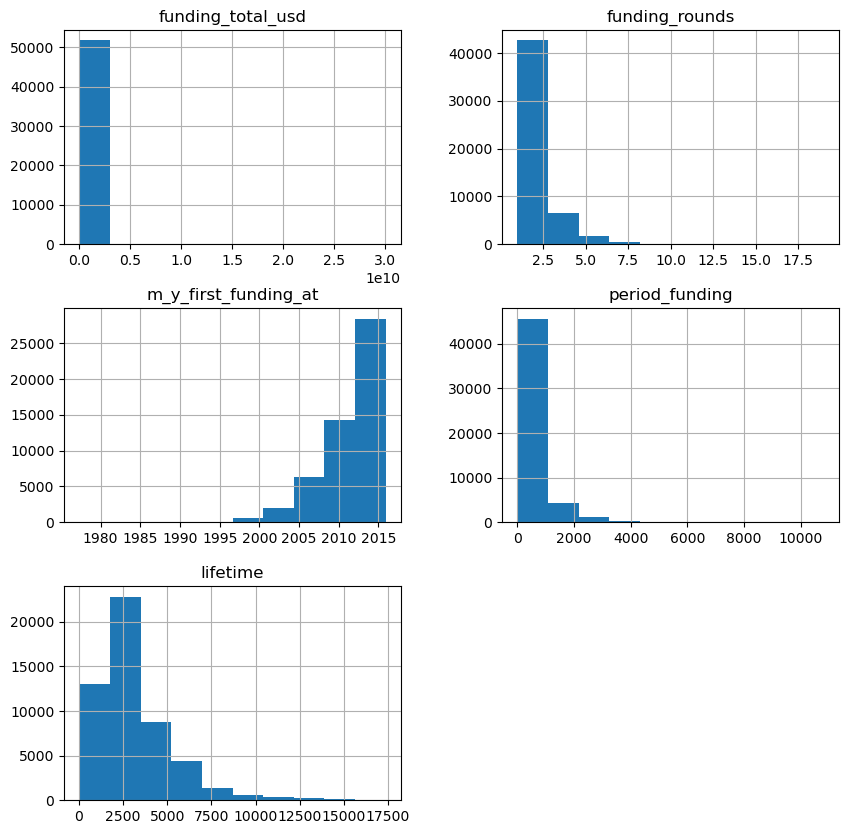

In [36]:
data_train.hist(figsize = (10, 10));

Удалим выбросы

In [37]:
data_train = data_train[data_train['funding_total_usd'] < 50000000]
data_train = data_train[data_train['funding_rounds'] <= 8]


In [38]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48668 entries, Lunchgate to Apparcando
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   status                48668 non-null  object        
 1   main_category         48668 non-null  object        
 2   funding_total_usd     48668 non-null  float64       
 3   country_code          48668 non-null  object        
 4   region                48668 non-null  object        
 5   funding_rounds        48668 non-null  int64         
 6   m_y_first_funding_at  48668 non-null  datetime64[ns]
 7   period_funding        48668 non-null  int64         
 8   lifetime              48668 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 3.7+ MB


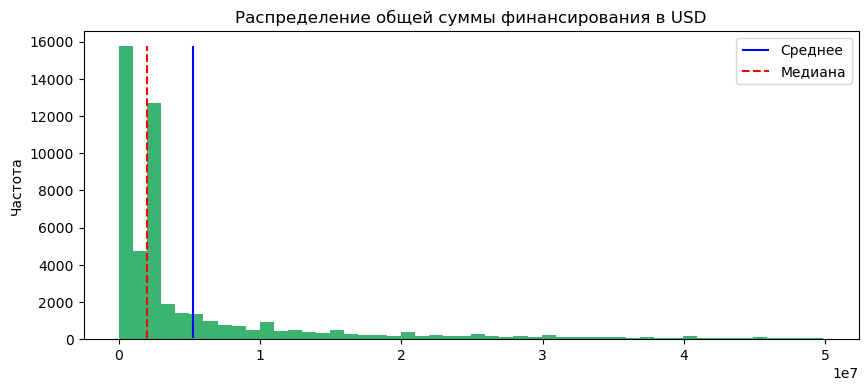

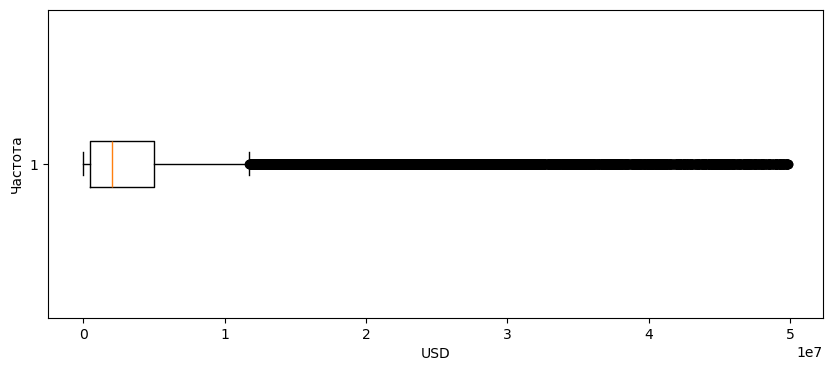

count    4.866800e+04
mean     5.212954e+06
std      8.803339e+06
min      1.000000e+00
25%      5.000000e+05
50%      2.000000e+06
75%      5.000000e+06
max      4.986000e+07
Name: funding_total_usd, dtype: float64

In [39]:
eda_number(data_train,
           'funding_total_usd',
           'Распределение общей суммы финансирования в USD',
           'USD',
           'mediumseagreen')


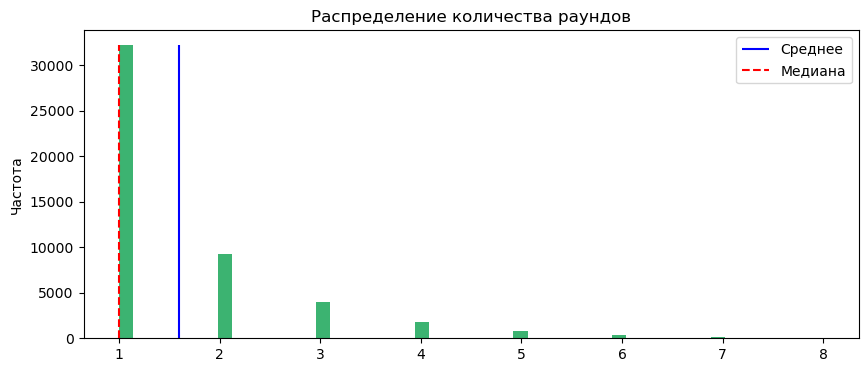

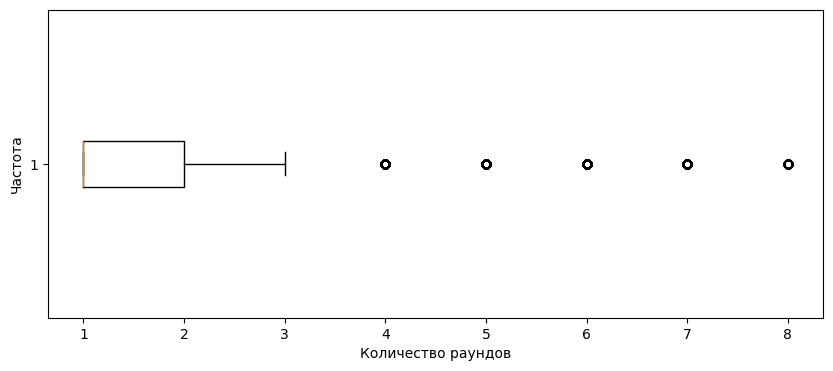

count    48668.000000
mean         1.599614
std          1.072026
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          8.000000
Name: funding_rounds, dtype: float64

In [40]:
eda_number(data_train,
           'funding_rounds',
           'Распределение количества раундов',
           'Количество раундов',
           'mediumseagreen')

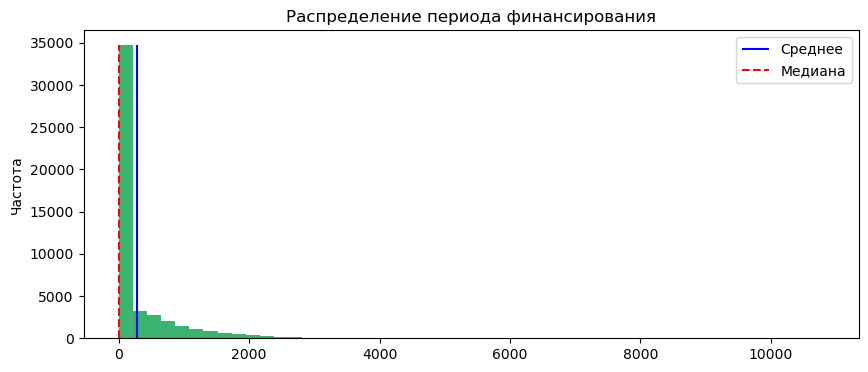

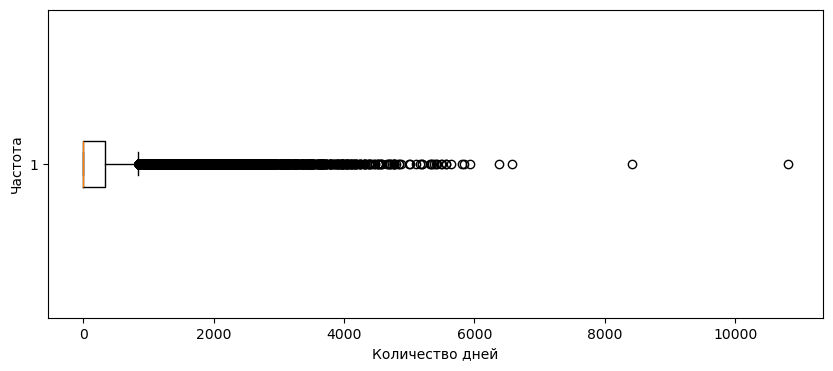

count    48668.000000
mean       282.082929
std        581.137080
min          1.000000
25%          1.000000
50%          1.000000
75%        339.000000
max      10808.000000
Name: period_funding, dtype: float64

In [41]:
eda_number(data_train,
           'period_funding',
           'Распределение периода финансирования',
           'Количество дней',
           'mediumseagreen')

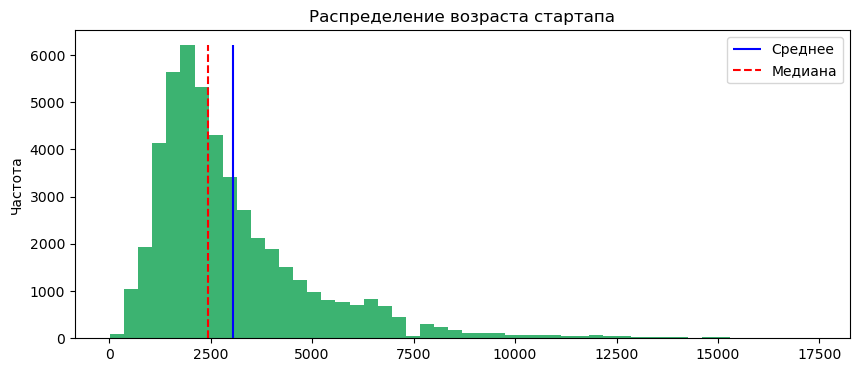

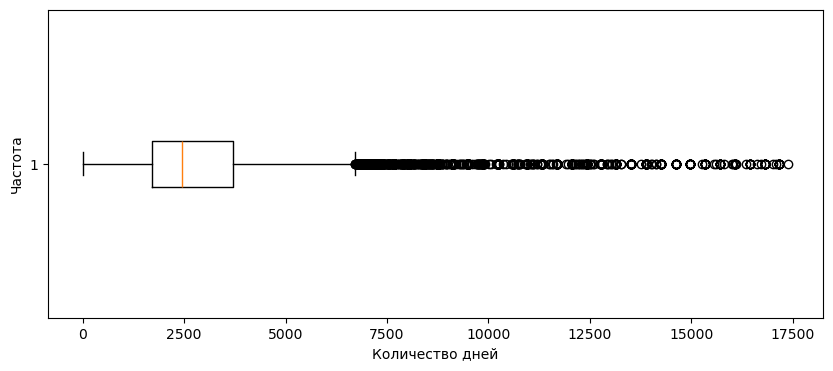

count    48668.000000
mean      3047.026506
std       2091.257453
min         20.000000
25%       1707.000000
50%       2446.000000
75%       3712.250000
max      17379.000000
Name: lifetime, dtype: float64

In [42]:
eda_number(data_train,
           'lifetime',
           'Распределение возраста стартапа',
           'Количество дней',
           'mediumseagreen')

In [43]:
#разделим датасет на два по целевому признаку
data_train_1 = data_train[data_train['status'] == 'operating']
data_train_0 = data_train[data_train['status'] == 'closed']


In [44]:
def eda_number_with_status(column, title, xlabel):
    #делаем таблица со статистикой для data_train_1 и data_train_0 в одной таблице
    desc_1 = data_train_1[column].describe()
    desc_0 = data_train_0[column].describe()
    combined_desc = pd.concat([desc_1, desc_0], axis=1)
    combined_desc.columns = ['открытые стартапы', 'закрытые стартапы']
    print(combined_desc)

    #добавляем 2 гистограммы на один график
    plt.hist(data_train_1[column], bins=50, alpha=0.3, label='operating', color='orchid')
    plt.hist(data_train_0[column], bins=50, alpha=0.3, label='closed')
    # Добавление подписей осей
    plt.xlabel(xlabel)
    plt.ylabel('Частота')
    plt.title(title)
    plt.legend()
    plt.show()

       открытые стартапы  закрытые стартапы
count       4.401000e+04       4.658000e+03
mean        5.285946e+06       4.523305e+06
std         8.876673e+06       8.045918e+06
min         1.000000e+00       2.000000e+00
25%         5.000000e+05       3.260625e+05
50%         2.000000e+06       2.000000e+06
75%         5.000000e+06       4.000000e+06
max         4.986000e+07       4.980080e+07


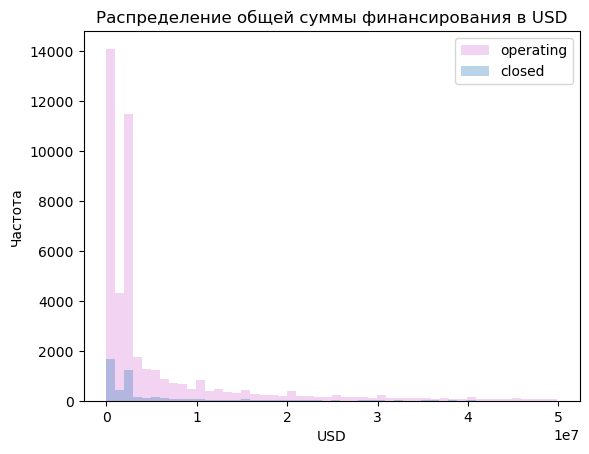

In [45]:
eda_number_with_status('funding_total_usd', 'Распределение общей суммы финансирования в USD', 'USD')

       открытые стартапы  закрытые стартапы
count       44010.000000        4658.000000
mean            1.626176           1.348647
std             1.091487           0.825797
min             1.000000           1.000000
25%             1.000000           1.000000
50%             1.000000           1.000000
75%             2.000000           1.000000
max             8.000000           8.000000


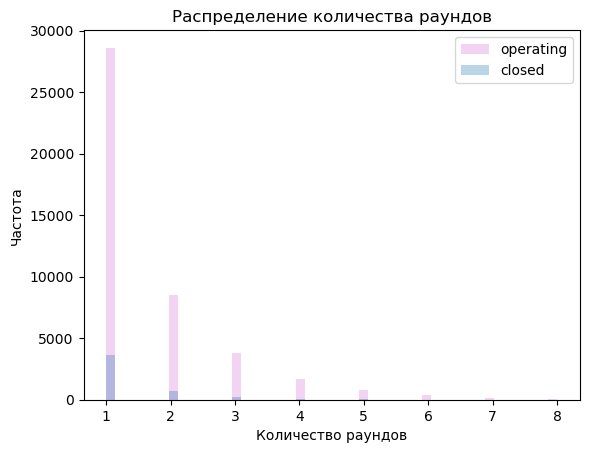

In [46]:
eda_number_with_status('funding_rounds', 'Распределение количества раундов', 'Количество раундов')

                   открытые стартапы              закрытые стартапы
count                          44010                           4658
mean   2011-10-28 07:44:17.668711680  2010-02-28 09:50:09.531987968
min              1977-05-01 00:00:00            1982-03-01 00:00:00
25%              2010-04-01 00:00:00            2007-11-01 00:00:00
50%              2012-11-01 00:00:00            2010-10-01 00:00:00
75%              2014-05-01 00:00:00            2013-06-23 12:00:00
max              2015-12-01 00:00:00            2015-12-01 00:00:00


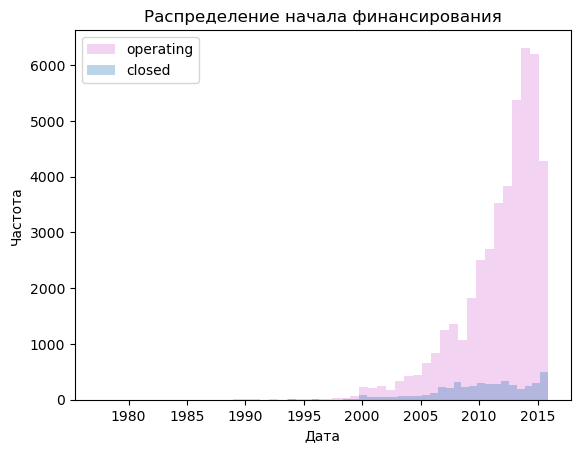

In [47]:
eda_number_with_status('m_y_first_funding_at', 'Распределение начала финансирования', 'Дата')

       открытые стартапы  закрытые стартапы
count       44010.000000        4658.000000
mean          295.533810         154.995492
std           594.545957         413.463163
min             1.000000           1.000000
25%             1.000000           1.000000
50%             1.000000           1.000000
75%           372.000000           1.000000
max         10808.000000        4354.000000


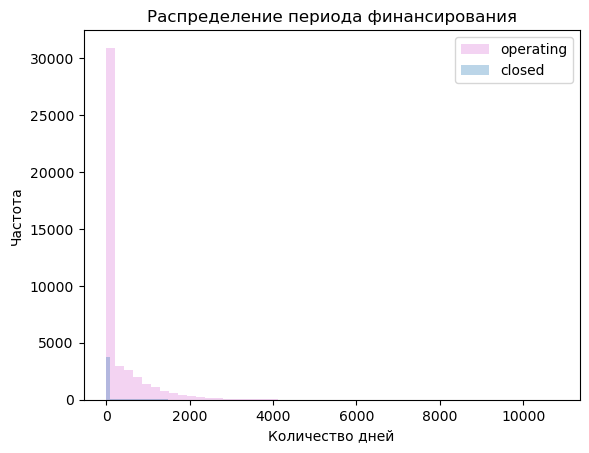

In [48]:
eda_number_with_status('period_funding', 'Распределение периода финансирования', 'Количество дней')

       открытые стартапы  закрытые стартапы
count       44010.000000        4658.000000
mean         3225.544672        1360.340275
std          2076.904239        1339.018962
min           732.000000          20.000000
25%          1827.000000         725.250000
50%          2558.000000         997.000000
75%          4018.000000        1368.000000
max         17379.000000       17005.000000


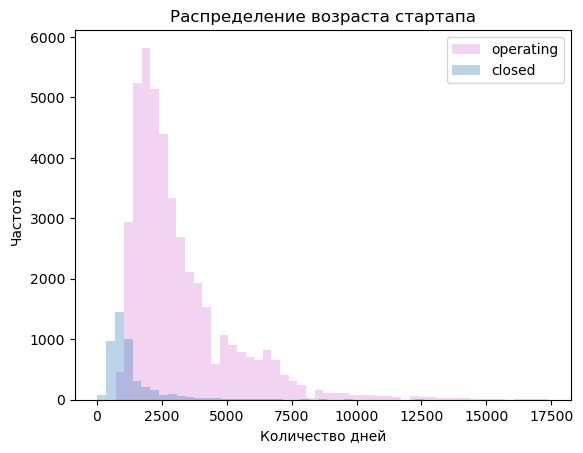

In [49]:
eda_number_with_status('lifetime', 'Распределение возраста стартапа', 'Количество дней')

## Иследовательский анализ данных категориальных признаков

Выведем все категориальные признаки 

In [50]:
print(data_train.select_dtypes(exclude=['number', 'datetime']).columns.tolist())

['status', 'main_category', 'country_code', 'region']


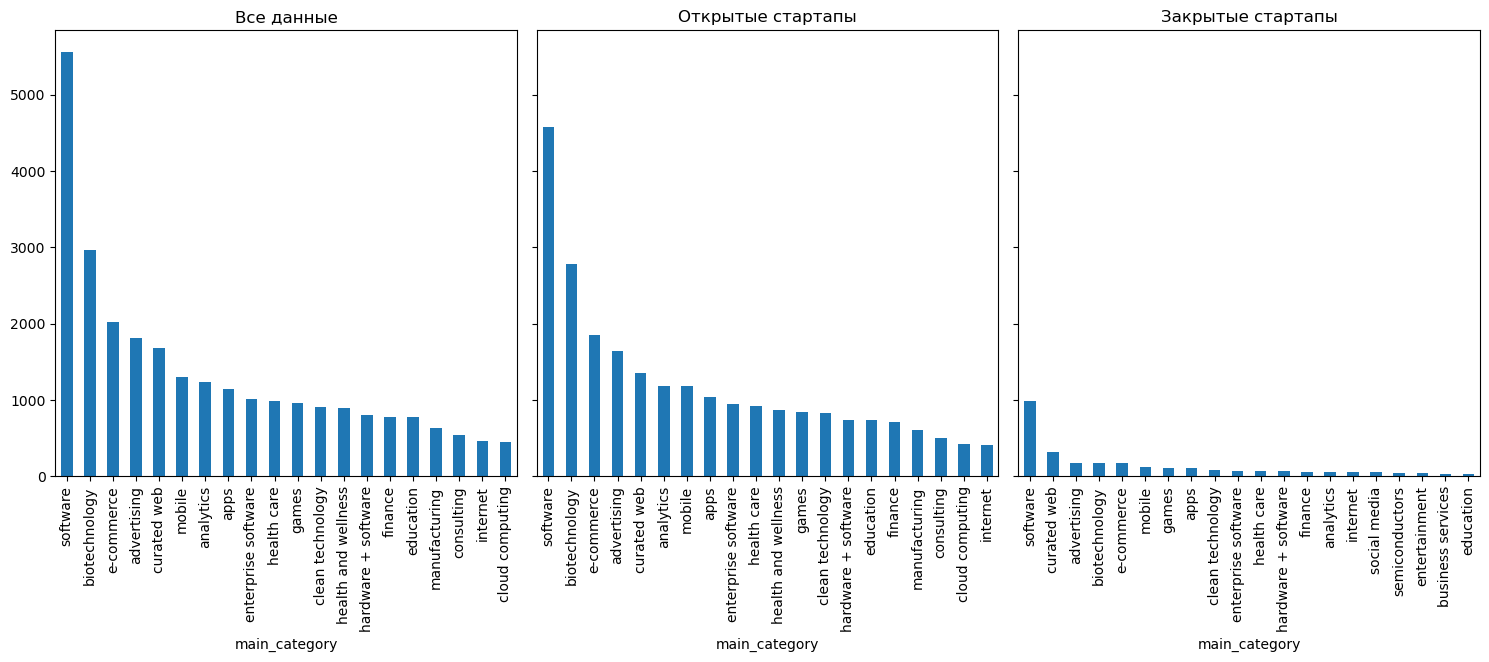

In [51]:
eda_category('main_category', 'Категории')

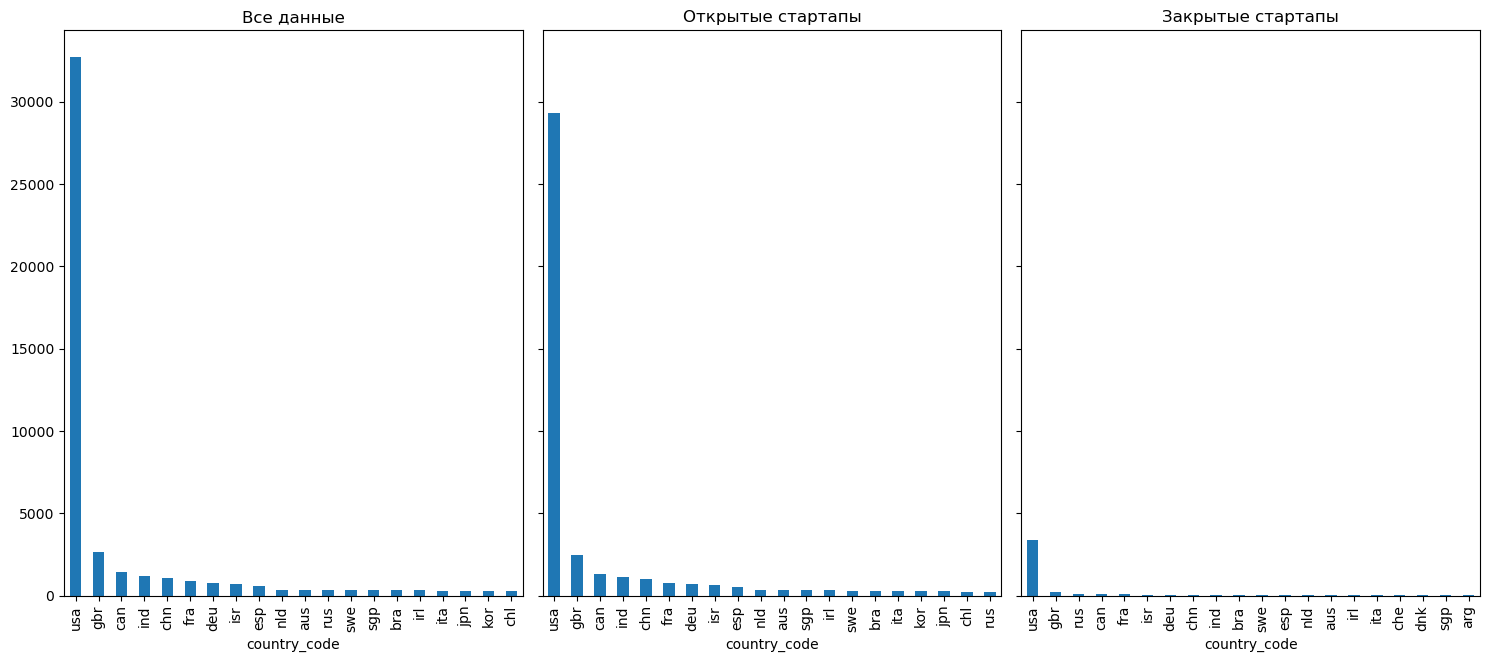

In [52]:
eda_category('country_code', 'Страны')

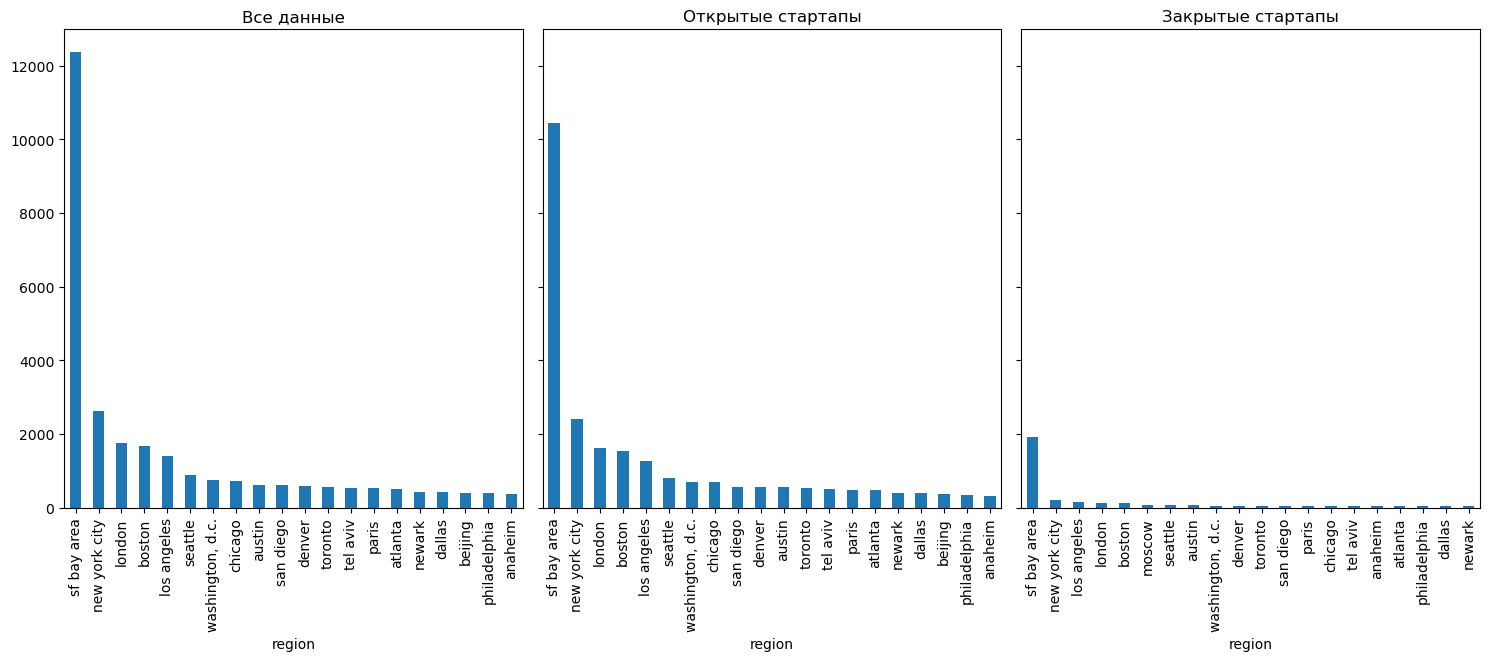

In [53]:
eda_category('region', 'Регионы')

## Корреляционный анализ признаков

Изучим взаимосвязь между признаками: рассчитаем коэффициенты корреляции между всеми числовыми признаками.

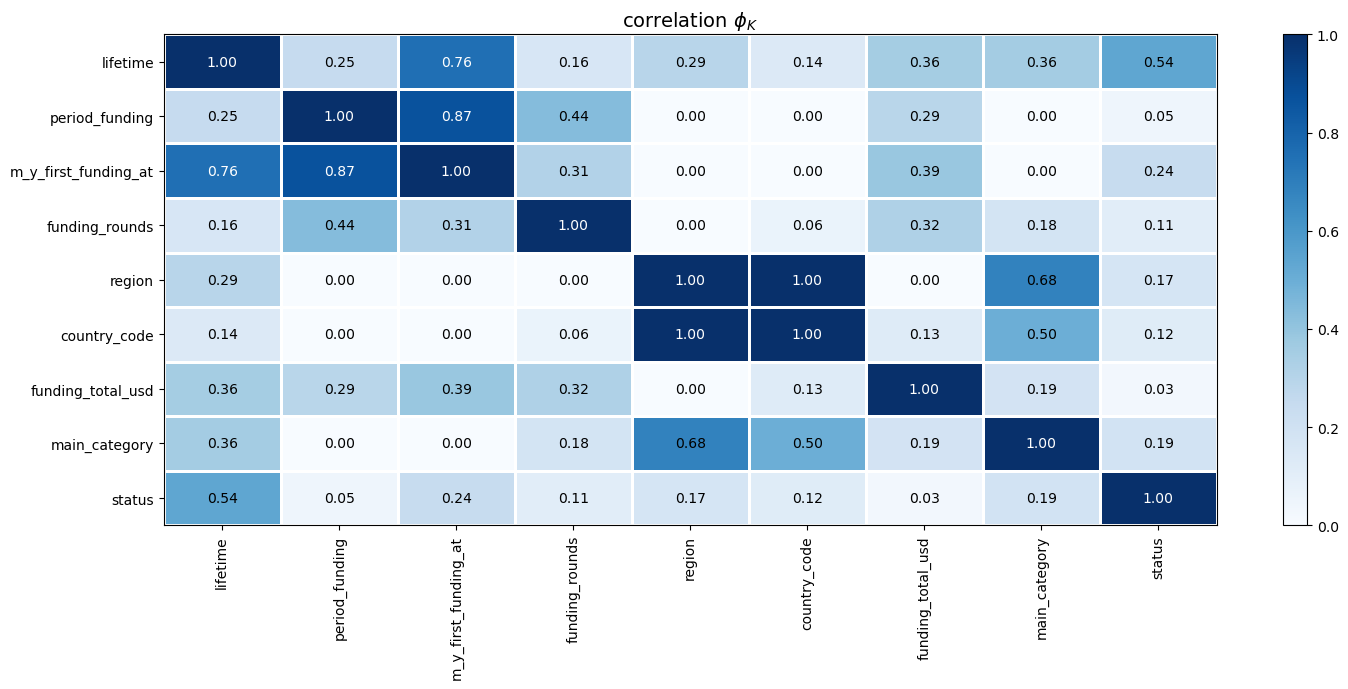

In [54]:
num_columns=data_train.select_dtypes('number').columns.tolist()
phik_overview = data_train.phik_matrix(interval_cols=num_columns)

# Визуализация матрицы корреляции
#plt.figure(figsize=(15, 7))
#sns.heatmap(phik_overview, annot=True, cmap='cividis')
#plt.title('Phi_K - корреляция между признаками')
# Отображение графика
#plt.tight_layout()
#plt.show()



plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, vmin=0, vmax=1, color_map='Blues', 
                        title=r'correlation $\phi_K$', fontsize_factor=1, figsize=(15, 7)) 
plt.tight_layout()
plt.show()

Закодируем целевой признак.

In [55]:
data_train['status'] = data_train['status'].apply(
    lambda x: 1 if x == 'operating' else 0
)

Корреляция между числовыми признаками


C:\Users\PC\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\PC\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\PC\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\PC\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

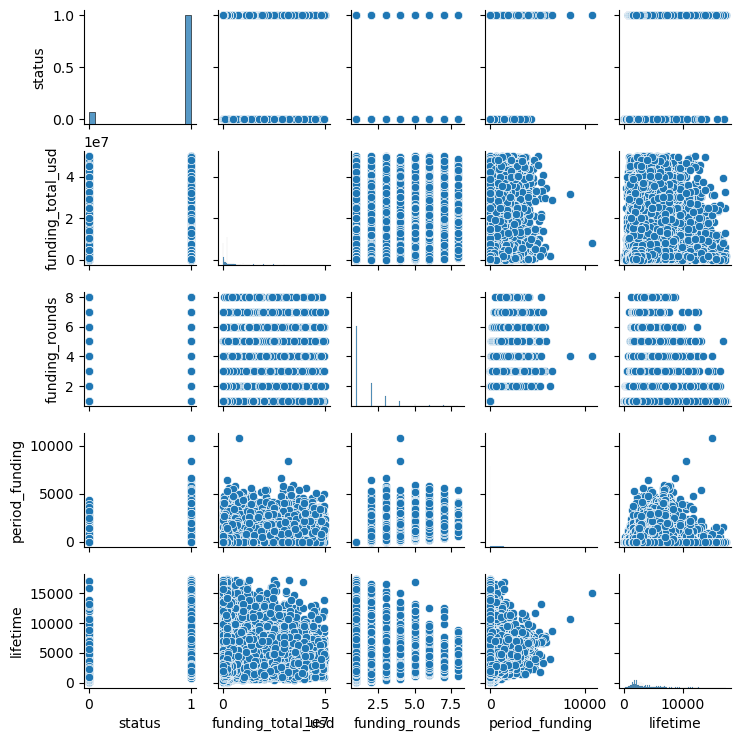

In [56]:
print('Корреляция между числовыми признаками')

_ = sns.pairplot(data_train.select_dtypes('number'), height=1.5)

## Мультиколлинеарность
Мультиколлинеарность принято учитывать при корреляции признаков выше 0.9, такая сильная зависимость в данных наблюдается в адресе, поэтому для обучения модели на данном этапе исключим признак регион.

In [57]:
data_train = data_train.drop(['region'], axis=1)
data_test = data_test.drop(['region'], axis=1)

### Выводы по результатам шага
На данном этапе проведен исследовательский анализ данных.

Были проверены все числовые и категориальные признаки, постороены гистраграммы и столбчатые диаграммы как по всем данным тренировочного датасета, так и в разрезе высокой и низкой удовлетворенности сотрудников.

Аномалии и выбросы в данных были выявлены и устранены. Это `funding_total_usd` > 50 000 000 USD  , а также `funding_rounds` > 8.

Диаграммы рассеяния, матрицы корреляции подтвердили выводы, сделанные на этапе проведения анализа числовых и категориальных данных.
Большинство признаков слабо коррелируют с целевым. Наибольшая зависимость , как и предполагалось, выявлена с признаком `lifetime`, но эта зависимость не превышает 0,9. Так же мы не можем абсолютно уверждать об утечке `lifetime`, так как если стартап новый и при этом успешный и ему в среднем ~1400 дней или даже меньше, то это не повод относить его в  closed. 

На основе исследовательского анализа мы можем составить портрет закрытого и открытого стартапа. У обоих видов очень схожие характеристики по всем признакам, но по некоорым есть небольшое отличие: `lifetime`, закрытые стартапы как правило в среднем имееют возраст 1361 день, а открытые  3225, медиана   997 против  2558 соответственно. Также различие замечено в признаке `funding_rounds`  - среднее количество раундов для открытых стартапов больше чем для закрытых -  1.622714 против  1.347854 шт , медиана в обоих стаутсах 1 день.  Также различие выявлено в новом, искусственно добавленном признаке - `period_funding`, для открытых в среднем это  294 дня, для закрытых -  156, медиана 1 в обоих случаях.

# Модель 1

## Подготовка данных для ML

In [58]:
data_train['status'].value_counts()

status
1    44010
0     4658
Name: count, dtype: int64

In [59]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48668 entries, Lunchgate to Apparcando
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   status                48668 non-null  int64         
 1   main_category         48668 non-null  object        
 2   funding_total_usd     48668 non-null  float64       
 3   country_code          48668 non-null  object        
 4   funding_rounds        48668 non-null  int64         
 5   m_y_first_funding_at  48668 non-null  datetime64[ns]
 6   period_funding        48668 non-null  int64         
 7   lifetime              48668 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 4.3+ MB


Необходимо преобразовать  тип данных datetime64[ns] в  `m_y_first_funding_at`. Разложим на компоненты - на день и год. 

In [60]:
data_train['year_first_funding_at'] = data_train['m_y_first_funding_at'].dt.year
data_train['month_first_funding_at'] = data_train['m_y_first_funding_at'].dt.month
data_train = data_train.drop(['m_y_first_funding_at'], axis = 1)

data_test['year_first_funding_at'] = data_test['m_y_first_funding_at'].dt.year
data_test['month_first_funding_at'] = data_test['m_y_first_funding_at'].dt.month
data_test = data_test.drop(['m_y_first_funding_at'], axis = 1)


In [61]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48668 entries, Lunchgate to Apparcando
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   status                  48668 non-null  int64  
 1   main_category           48668 non-null  object 
 2   funding_total_usd       48668 non-null  float64
 3   country_code            48668 non-null  object 
 4   funding_rounds          48668 non-null  int64  
 5   period_funding          48668 non-null  int64  
 6   lifetime                48668 non-null  float64
 7   year_first_funding_at   48668 non-null  int32  
 8   month_first_funding_at  48668 non-null  int32  
dtypes: float64(2), int32(2), int64(3), object(2)
memory usage: 4.3+ MB


В данных дисбаланс классов, будем исползовать стратификацию при деленнии датасета на выборки.

In [62]:
#разбиваем данные на тестовые и тренировочные выборки
X_train, X_test, y_train, y_test = train_test_split(
    data_train.drop(['status'], axis=1),
    data_train['status'],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=data_train['status']
)

In [63]:
print(np.bincount(y_train))

[ 3493 33008]


Класс 0 встречается почти в 10 раз реже, это грозит тем , что модель почти всегда будет предсказывать 1. Необходимо устранить дисбаланс классов.

In [64]:
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)

X_train (36501, 8)
X_test (12167, 8)
y_train (36501,)
y_test (12167,)


Разбивка на учебную и тестовые выборки прошла успешно.

In [65]:
num_columns = data_train.select_dtypes(include=['number', 'datetime']).drop(['status'], axis=1).columns.tolist()

ohe_columns = data_train.select_dtypes(exclude=['number', 'datetime']).columns.tolist()


In [66]:
print('ohe_columns:', ohe_columns)

print('num_columns:', num_columns)

ohe_columns: ['main_category', 'country_code']
num_columns: ['funding_total_usd', 'funding_rounds', 'period_funding', 'lifetime', 'year_first_funding_at', 'month_first_funding_at']


In [67]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: OHE-кодирование
ohe_pipe = Pipeline([   
    ('simpleImputer_before_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')),
    ('simpleImputer_after_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

# Создаем пайплайн для подготовки признаков из списка num_columns
# проводим масштабирование, Используем StandardScaler по умолчанию
num_pipe = Pipeline([
    ('scaler', StandardScaler())  
])


data_preprocessor = ColumnTransformer(
        [
            ('ohe', ohe_pipe, ohe_columns),
            ('num', num_pipe, num_columns)
        ],
        remainder='passthrough'
    )

На текущем шаге в пайплайнах использовали только кодировщики данных для заранее определенных списков колонок.

Пайплайны подготовлены, можно переходить к обучению моделей.

## Обучение модели
Обучим четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression().  -
Для ценки модели была выбрана метрика F1, F1 является гармоническим средним между Recall и Precision. Хорошая модель при обучении будет максимизировать Recall и Precision одновременно. Таким образом, умеренно хорошие показатели по обоим параметрам будут предпочтительнее, чем чрезвычайно хорошие показатели по одному и плохие по другому.

Также будем использовать на тестовой выборке  Precision-Recall AUC (PR AUC). ROC AUC оценивает способность модели различать классы, независимо от их распределения в данных. Это особенно полезно, когда в данных наблюдается дисбаланс.

Метрика PR AUC используется для оценки качества модели в случае дисбалансированных классов, особенно когда важно учитывать как precision (точность), так и recall (полноту). Она полезна, когда классы сильно несбалансированы, и ROC-AUC может быть не так информативна.



In [68]:
pr_auc_scorer = make_scorer(average_precision_score, needs_proba=True)

In [69]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    #('smote', SMOTE(random_state=RANDOM_STATE)),
    ('models', KNeighborsClassifier())
])

param_distributions = [
   #словарь для модели DecisionTreeClassifier
   
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        'models__max_depth': range(2, 10),
        'models__max_features': range(2, 12),
        'models__min_samples_split': range(1, 10),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'] 
   },
    
    # словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 13),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'] #указываем только название скейлера  
    },
    
    #словарь для модели LogisticRegression
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')],
        'models__C': [0.01, 0.1, 1, 10],
        'models__penalty': ['l1', 'l2'],
        'models__solver': ['liblinear'],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    } 
]

#перебор вариантов масштабирования и  гипермараметров модели


randomized_search = RandomizedSearchCV(
    pipe_final,
    param_distributions,
    cv=5,
    scoring='f1_weighted',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_before_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False)),
                                                                                               ('simpleImputer_after_ohe',
                                                                                                SimpleImputer(strategy='most_...
                                         'preprocessor__num__scaler': [StandardScaler(),
                                                                       MinMaxScaler(),
                                                                       RobustScaler(),
                                                                       'passthrough']},
                                        {'models': [LogisticRegression(class_weight='balanced',
                                                                       random_state=87)],
                                         'models__C': [0.01, 0.1, 1, 10],
                                         'models__penalty': ['l1', 'l2'],
                                         'models__solver': ['liblinear'],
                                         'preprocessor__num__scaler': [StandardScaler(),
                                                                       MinMaxScaler(),
                                                                       RobustScaler(),
                                                                       'passthrough']}],
                   random_state=87, scoring='f1_weighted')

In [70]:
y_pred = randomized_search.predict(X_test)
y_pred_proba = randomized_search.predict_proba(X_test)[:, 1]

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print('Лучший скейлер:', randomized_search.best_params_['preprocessor__num__scaler'])
print('F1  на тренировочной выборке:', randomized_search.best_score_)
print('F1 на тестовой выборке:', f1_score(y_test, y_pred, average="weighted"))
print('Av ROC-AUC на тестовой выборке:', average_precision_score(y_test, y_pred_proba))

C:\Users\PC\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\PC\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_before_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('simpleImputer_after_ohe',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                              

In [71]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.12      0.00      0.01      1165
           1       0.90      1.00      0.95     11002

    accuracy                           0.90     12167
   macro avg       0.51      0.50      0.48     12167
weighted avg       0.83      0.90      0.86     12167



In [72]:
print(np.unique(y_pred, return_counts=True))  # Посмотрим, предсказывает ли модель 0 и 1

(array([0, 1], dtype=int64), array([   26, 12141], dtype=int64))


#№ Анализ важности признаков

In [73]:
# Получаем список всех признаков после трансформации
feature_names = randomized_search.best_estimator_['preprocessor'].get_feature_names_out()

# Создаём DataFrame с важностью признаков
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': randomized_search.best_estimator_['models'].feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importance.head(20))

                                    Feature  Importance
508             ohe__main_category_services    0.287719
294             ohe__main_category_hardware    0.222364
260              ohe__main_category_fintech    0.201859
606                   ohe__country_code_ken    0.161126
644                   ohe__country_code_ury    0.060595
590                   ohe__country_code_gbr    0.039459
583                   ohe__country_code_dnk    0.013340
589                   ohe__country_code_fra    0.012969
603                   ohe__country_code_ita    0.000570
435        ohe__main_category_online gaming    0.000000
430                  ohe__main_category_oil    0.000000
431            ohe__main_category_oil & gas    0.000000
432          ohe__main_category_oil and gas    0.000000
433        ohe__main_category_online dating    0.000000
434     ohe__main_category_online education    0.000000
0            ohe__main_category_3d printing    0.000000
436      ohe__main_category_online identity    0

# Модель 2

## Подготовка данных для ML

Уберем признак `main_category` и посмореть на метрики. 

In [74]:
data_train_2 = data_train.drop(['main_category', 'country_code'], axis=1)
data_test_2 = data_test.drop(['main_category', 'country_code'], axis=1)

In [75]:
data_train_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48668 entries, Lunchgate to Apparcando
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   status                  48668 non-null  int64  
 1   funding_total_usd       48668 non-null  float64
 2   funding_rounds          48668 non-null  int64  
 3   period_funding          48668 non-null  int64  
 4   lifetime                48668 non-null  float64
 5   year_first_funding_at   48668 non-null  int32  
 6   month_first_funding_at  48668 non-null  int32  
dtypes: float64(2), int32(2), int64(3)
memory usage: 3.6+ MB


In [76]:
data_test_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13125 entries, Crystalsol to RingCentral
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   funding_total_usd       13125 non-null  float64
 1   funding_rounds          13125 non-null  int64  
 2   period_funding          13125 non-null  int64  
 3   lifetime                13125 non-null  int64  
 4   year_first_funding_at   13125 non-null  int32  
 5   month_first_funding_at  13125 non-null  int32  
dtypes: float64(1), int32(2), int64(3)
memory usage: 615.2+ KB


In [77]:
#разбиваем данные на тестовые и тренировочные выборки
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    data_train_2.drop(['status'], axis=1),
    data_train_2['status'],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=data_train_2['status']
)

In [78]:
print(np.bincount(y_train_2))

[ 3493 33008]


In [79]:
print('X_train_2', X_train_2.shape)
print('X_test_2', X_test_2.shape)
print('y_train_2', y_train_2.shape)
print('y_test_2', y_test_2.shape)

X_train_2 (36501, 6)
X_test_2 (12167, 6)
y_train_2 (36501,)
y_test_2 (12167,)


Разбивка на учебную и тестовые выборки прошла успешно.

In [80]:
num_columns_2 = data_train_2.select_dtypes(include=['number', 'datetime']).drop(['status'], axis=1).columns.tolist()

ohe_columns_2 = data_train_2.select_dtypes(exclude=['number', 'datetime']).columns.tolist()


In [81]:
print('ohe_columns_2:', ohe_columns_2)

print('num_columns_2:', num_columns_2)

ohe_columns_2: []
num_columns_2: ['funding_total_usd', 'funding_rounds', 'period_funding', 'lifetime', 'year_first_funding_at', 'month_first_funding_at']


In [82]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: OHE-кодирование
ohe_pipe_2 = Pipeline([   
    ('simpleImputer_before_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')),
    ('simpleImputer_after_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

# Создаем пайплайн для подготовки признаков из списка num_columns
# проводим масштабирование, Используем StandardScaler по умолчанию
num_pipe_2 = Pipeline([
    ('scaler', StandardScaler())  
])


data_preprocessor_2 = ColumnTransformer(
        [
            ('ohe', ohe_pipe_2, ohe_columns_2),
            ('num', num_pipe_2, num_columns_2)
        ],
        remainder='passthrough'
    )

## Обучение модели

In [83]:
pipe_final_2 = Pipeline([
    ('preprocessor', data_preprocessor_2),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('models', KNeighborsClassifier())
])

param_distributions = [
   #словарь для модели DecisionTreeClassifier
   
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        'models__max_depth': range(2, 12),
        'models__max_features': range(2, 12),
        'models__min_samples_split': range(1, 12),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'] 
   },
    
    # словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 13),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'] #указываем только название скейлера  
    },
    
    #словарь для модели LogisticRegression
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')],
        'models__C': [0.01, 0.1, 1, 10],
        'models__penalty': ['l1', 'l2'],
        'models__solver': ['liblinear'],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    } 
]
randomized_search_2 = RandomizedSearchCV(
    pipe_final_2,
    param_distributions,
    cv=5,
    scoring='f1_weighted',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search_2.fit(X_train_2, y_train_2)



RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_before_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False)),
                                                                                               ('simpleImputer_after_ohe',
                                                                                                SimpleImputer(strategy='most_...
                                         'preprocessor__num__scaler': [StandardScaler(),
                                                                       MinMaxScaler(),
                                                                       RobustScaler(),
                                                                       'passthrough']},
                                        {'models': [LogisticRegression(class_weight='balanced',
                                                                       random_state=87)],
                                         'models__C': [0.01, 0.1, 1, 10],
                                         'models__penalty': ['l1', 'l2'],
                                         'models__solver': ['liblinear'],
                                         'preprocessor__num__scaler': [StandardScaler(),
                                                                       MinMaxScaler(),
                                                                       RobustScaler(),
                                                                       'passthrough']}],
                   random_state=87, scoring='f1_weighted')

In [84]:
y_pred_2 = randomized_search_2.predict(X_test_2)
y_pred_proba_2 = randomized_search_2.predict_proba(X_test_2)[:, 1]

print('Лучшая модель и её параметры:\n\n', randomized_search_2.best_estimator_)
print('Лучший скейлер:', randomized_search_2.best_params_['preprocessor__num__scaler'])
print('F1 на тренировочной выборке:', randomized_search_2.best_score_)
print('F1 на тестовой выборке:', f1_score(y_test_2, y_pred_2, average="weighted"))
print('Av ROC-AUC на тестовой выборке:', average_precision_score(y_test_2, y_pred_proba_2))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_before_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('simpleImputer_after_ohe',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                              

In [85]:
print(classification_report(y_test_2, y_pred_2))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86      1165
           1       0.98      0.99      0.99     11002

    accuracy                           0.97     12167
   macro avg       0.93      0.92      0.92     12167
weighted avg       0.97      0.97      0.97     12167



In [86]:
# Получаем список всех признаков после трансформации
feature_names_2 = randomized_search_2.best_estimator_['preprocessor'].get_feature_names_out()

# Создаём DataFrame с важностью признаков
feature_importance_2 = pd.DataFrame({
    'Feature': feature_names_2,
    'Importance': randomized_search_2.best_estimator_['models'].feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importance_2.head(20))

                       Feature  Importance
3                num__lifetime    0.728163
4   num__year_first_funding_at    0.256666
5  num__month_first_funding_at    0.007580
0       num__funding_total_usd    0.004146
2          num__period_funding    0.002987
1          num__funding_rounds    0.000458


# Предсказание по тестовому датасету

In [87]:
best_model = randomized_search_2.best_estimator_
prediction = best_model.predict(data_test_2)
data_test_2['status'] = prediction
data_test_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13125 entries, Crystalsol to RingCentral
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   funding_total_usd       13125 non-null  float64
 1   funding_rounds          13125 non-null  int64  
 2   period_funding          13125 non-null  int64  
 3   lifetime                13125 non-null  int64  
 4   year_first_funding_at   13125 non-null  int32  
 5   month_first_funding_at  13125 non-null  int32  
 6   status                  13125 non-null  int64  
dtypes: float64(1), int32(2), int64(4)
memory usage: 717.8+ KB


In [88]:
data_test_2['status'] = data_test_2['status'].apply(
    lambda x: 'operating' if x == 1  else 'closed'
)
startups_sample_submit = data_test_2.reset_index(names='name')
startups_sample_submit = startups_sample_submit[['name', 'status']]
startups_sample_submit['status'].value_counts()

status
operating    11928
closed        1197
Name: count, dtype: int64

In [89]:
startups_sample_submit.to_csv("startups_sample_submit.csv", index=False)

# Общий вывод

Задачей данного проекта было создание модели которая сможет на основе данных за несколько десятилейти сможет предсказать закроется стартап или нет. Данные модели смогут помочь инвесторам минимизировать риски от вложений в неудачные стартапы.

В ходе выполнения проекта были загружены, обработаны и исследованы данные о стартапах с 1980-2018гг. Был проведен исследовательский и корреляционый анализ данных, на их основе составлен портрет закрытого и открытого стартапа.

Были проверены все числовые и категориальные признаки, постороены гистраграммы и столбчатые диаграммы как по всем данным тренировочного датасета, так и в разрезе высокой и низкой удовлетворенности сотрудников.

Диаграммы рассеяния, матрицы корреляции подтвердили выводы, сделанные на этапе проведения анализа числовых и категориальных данных. Большинство признаков слабо коррелируют с целевым. Наибольшая зависимость , выявлена с признаком lifetime, но эта зависимость не превышает 0,9. Так же мы не можем абсолютно уверждать об утечке lifetime, так как если стартап новый и при этом успешный и ему в среднем ~1400 дней или даже меньше, то это не повод относить его в closed.

На основе исследовательского анализа мы можем составить портрет закрытого и открытого стартапа. У обоих видов очень схожие характеристики по всем признакам, но по некоорым есть небольшое отличие: lifetime, закрытые стартапы как правило в среднем имееют возраст 1361 день, а открытые 3225, медиана 997 против 2558 соответственно. Также различие замечено в признаке funding_rounds - среднее количество раундов для открытых стартапов больше чем для закрытых - 1.622714 против 1.347854 шт , медиана в обоих стаутсах 1 день. Также различие выявлено в новом, искусственно добавленном признаке - period_funding, для открытых в среднем это 294 дня, для закрытых - 156, медиана 1 в обоих случаях.


Для обучения использовались две модели на данных с разным набором признаков. Из второго набора был исключен признак с категориями и странам, так как они даже после обработки имели очень высокую уникальность, из -за этого не получалось в первой модели достичь высокой метрики f1.
Кодирование, масштабировние и заполнение пропусков проводили в пайплайне перебирая различные параметры модели с помощью кросс-валидации. Лучшими моделями были признаны:

модель , позволяющая спрогнозировать закроется стартап или нет: DecisionTreeClassifier(class_weight='balanced', max_depth=8, max_features=7, random_state=87)
Лучший скейлер: passthrough
F1 на тренировочной выборке: 0.9733255712336941
F1 на тестовой выборке: 0.9741619437472105
Av ROC-AUC на тестовой выборке: 0.9858732854067875

Ркомендации по улучшению работы модель: необходимо уделить внимание предобработке данных, создать супер-категории для признаков `category_list`, так же обрабоать города , проверить наличие неявных дубликатов, корректнее заполнить пропуски в географических данных - `region`, `state`, `city`, предварительно сгруппировав данные по стране.